# EDA Summary

1. In the given dataset we have 8 categorical features and 369 numerical features.
2. Scatter plot,PDF and CDF for Y target variable showed most values lie between 80 and 140. There are 99% values below 150 and 150 is taken as threshold for target variable.
3. Using Scatter plot on ID vs Target variable showed ID does not have much impact on target. So ID was removed from the dataset.
4. Using Seaborn and Matplot libraries to plot Bar and Scatter plots for Categorical varibales. There were some outliers present in the dataset.
5. Found that the feature X4 has the lowest variance among categorical variables, so it was removed from the datset.
6. There are 12 features which had same value across the dataset when analysing numerical features. These 12 features are removed from the dataset.
7. Used Recursive Feature Elimination to select top features from Numerical Features and created a heatmap using correlation. There were some columns which exhibited multicollinearity. So the Multicollinear columns was removed from dataset.
8. Used Random Forests on Numerical data to get top features which have more impact on y.

# FE Summary

1. The final dataset from EDA had 318 columns total.
2. Created Correlation features from the top features i got from Random forest model.
3. Used Elbow method to select the optimum number of features for PCA. Created PCA features fpr Numerical columns of our dataset.
4. Used Thresholding of singluar values (https://arxiv.org/pdf/1305.5870.pdf) paper to get optimum rank for creating TSVD features. Created TSVD features based on the optimum rank for Numerical columns of our dataset.
5. For categorical features, I have used Label Encoding, Mean Encoding and GLMM Encoding and created datasets.
6. For every type of Encoding I created below three types of datasets

  Encoding + Interaction features

  Encoding + Interaction + PCA features

  Encoding + Interaction + TSVD features

# Models

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
test_id = pd.read_csv('test.csv')
test_id = test_id[['ID']]

In [3]:
# Train file saved from EDA
train_org = pd.read_csv('preprocessed_train.csv')

In [4]:
y_train = train_org[['y']]

## Importing data

##### This is normalized data and consists of label encoding of categorical features with no added features to original train.

In [5]:
label_train = pd.read_csv('label_encoding/preprocessed_train_norm_label.csv')
label_test = pd.read_csv('label_encoding/preprocessed_test_norm_label.csv')

###### This is normalized data and consists of mean encoding of categorical features with no added features to original train.

In [6]:
mean_train = pd.read_csv('mean_encoding/preprocessed_train_norm_mean.csv')
mean_test = pd.read_csv('mean_encoding/preprocessed_test_norm_mean.csv')

##### This is normalized data and consists of glmm encoding of categorical features with no added features to original train.

In [7]:
glmm_train = pd.read_csv('glmm_encoding/preprocessed_train_norm_glmm.csv')
glmm_test = pd.read_csv('glmm_encoding/preprocessed_test_norm_glmm.csv')

In [8]:
bins = []
for i in y_train.values:
    if i >70 and i<=90:
        bins.append('a')
    elif i >90 and i<=110:
        bins.append('b')
    elif i>110 and i<= 130:
        bins.append('c')
    elif i>130 and i<=160:
        bins.append('d')

In [9]:
bins = pd.DataFrame(bins,columns = ['bin'])

In [10]:
skf = StratifiedKFold(n_splits=10)
cv_indices = []
for train,test in skf.split(train_org,bins):
    cv_indices.append((train,test))

## GridSearchCV

In [11]:
# Hyperparamter tuning for LR model, plotting of R2 scores
def Lr_model(model,params,x_train):
    grid_model = GridSearchCV(model,params,return_train_score = True,cv = cv_indices,scoring = 'r2')
    grid_model.fit(x_train,y_train)
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
    scores_df = pd.DataFrame(grid_model.cv_results_)
    train_scores = scores_df['mean_train_score']
    cv_scores = scores_df['mean_test_score']
    plt.figure(figsize = (10,5))
    plt.plot(np.log10(param['alpha']),train_scores,label = 'Train scores')
    plt.plot(np.log10(param['alpha']),cv_scores,label = 'CV Scores')
    plt.scatter(np.log10(param['alpha']),train_scores)
    plt.scatter(np.log10(param['alpha']),cv_scores)
    plt.xlabel('Log of alphas')
    plt.ylabel('R2 scores')
    plt.grid()
    plt.legend()
    plt.show()
    print('Best R2 score is ', grid_model.best_score_, 'and best hyperparameters is ',grid_model.best_params_)
    return grid_model

## RandomizedSearchCV

In [12]:
def ensemble(model,params,x_train):
    rs_model = RandomizedSearchCV(model,params,return_train_score = True,cv = cv_indices,scoring = 'r2',n_jobs = -1)
    rs_model.fit(x_train,y_train['y'].values)
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
    scores_df = pd.DataFrame(rs_model.cv_results_)
    train_scores = scores_df['mean_train_score']
    cv_scores = scores_df['mean_test_score']
    fold = list(range(1,11))
    plt.figure(figsize = (10,5))
    plt.plot(fold,train_scores,label = 'Train scores')
    plt.plot(fold,cv_scores,label = 'CV Scores')
    plt.scatter(fold,train_scores)
    plt.scatter(fold,cv_scores)
    plt.xlabel('Folds')
    plt.ylabel('R2 scores')
    plt.grid()
    plt.legend()
    plt.show()
    print('Best R2 score is ', rs_model.best_score_, 'and best hyperparameters is ',rs_model.best_params_)
    return rs_model

In [13]:
def feature_imp(model,train):
    features = train.columns
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[-20:]
    plt.figure(figsize=(10,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importance[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [14]:
# Funciton which returns the predicted values of test set in submssion csv format.
def submission(model,x_test):
    y_predicted = model.predict(x_test)
    submission_df = pd.DataFrame()
    submission_df['ID'] = test_id['ID']
    submission_df['y'] = y_predicted
    return submission_df

In [15]:
#Function which saves the models to the folder
def save_model(name,model):
    filename = 'models/'+str(name)+'.sav'
    pickle.dump(model,open(filename,'wb'))

## Data (encoding of categorical variables)

### Linear Regression Models

#### Label Encoding

In [16]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98559.51599865893, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95783.44316762884, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93226.07200345966, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want 

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50042.06680418382, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210.9555203083437, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1372.665636903199, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might wan

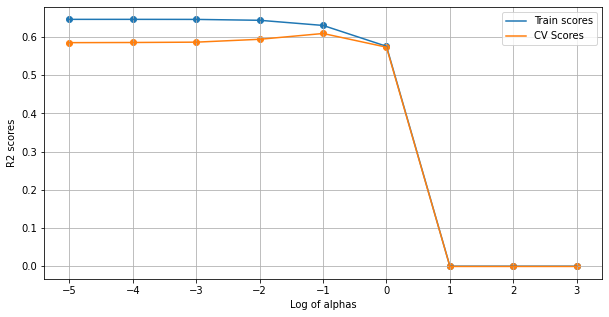

Best R2 score is  0.6092089989919909 and best hyperparameters is  {'alpha': 0.1}


In [17]:
#Hyperparameter tuning of Lasso model
label_lr_model = Lr_model(Lasso(),param,label_train)

# Best model from the hyperparameter tuning
label_lr_final = label_lr_model.best_estimator_
label_lr_final.fit(label_train,y_train)

# Final submission.csv for kaggle scores
label_submission = submission(label_lr_final,label_test)
save_model('label_lr_final',label_lr_final)

In [18]:
label_submission.to_csv('label_submission/label_lasso_submission.csv',index = False)

#### Mean Encoding

In [19]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93057.94357380987, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90262.7110973402, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88005.06315605286, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want t

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53204.98233676349, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


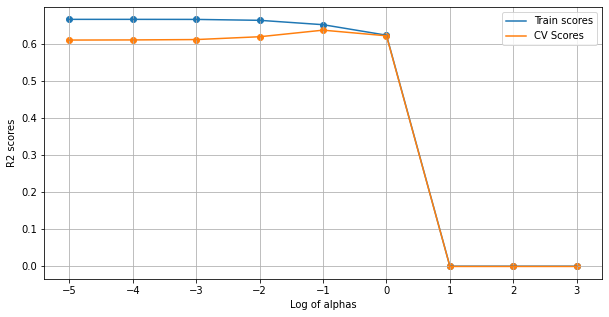

Best R2 score is  0.6365020383371386 and best hyperparameters is  {'alpha': 0.1}


In [20]:
#Hyperparameter tuning of Lasso model
mean_lr_model = Lr_model(Lasso(),param,mean_train)

# Best model from the hyperparameter tuning
mean_lr_final = mean_lr_model.best_estimator_
mean_lr_final.fit(mean_train,y_train)

# Final submission.csv for kaggle scores
mean_submission = submission(mean_lr_final,mean_test)
save_model('mean_lr_final',mean_lr_final)

In [21]:
mean_submission.to_csv('mean_submission/mean_lasso_submission.csv',index = False)

#### GLMM encoding

In [22]:
param = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93037.415617697, tolerance: 54.214141006722315
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90315.55511491738, tolerance: 54.384691712930604
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88245.98774946883, tolerance: 54.12183418301273
  model = cd_fast.enet_coordinate_descent(
c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to

c:\Miniconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53826.99817669993, tolerance: 54.578088292699356
  model = cd_fast.enet_coordinate_descent(


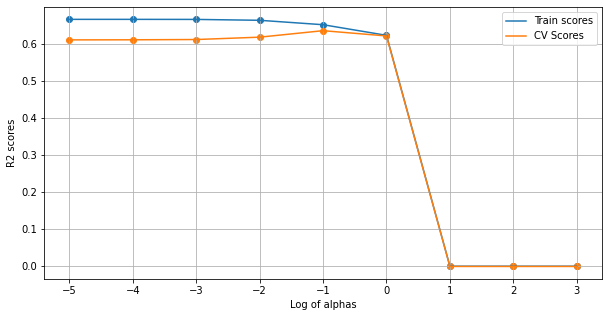

Best R2 score is  0.6350217688929376 and best hyperparameters is  {'alpha': 0.1}


In [23]:
#Hyperparameter tuning of Lasso model
glmm_lr_model = Lr_model(Lasso(),param,glmm_train)

# Best model from the hyperparameter tuning
glmm_lr_final = glmm_lr_model.best_estimator_
glmm_lr_final.fit(glmm_train,y_train)

# Final submission.csv for kaggle scores
glmm_submission = submission(glmm_lr_final,glmm_test)
save_model('glmm_lr_final',glmm_lr_final)

In [24]:
glmm_submission.to_csv('glmm_submission/glmm_lasso_submission.csv',index = False)

### Random Forest Models

#### Label Encoding

In [25]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


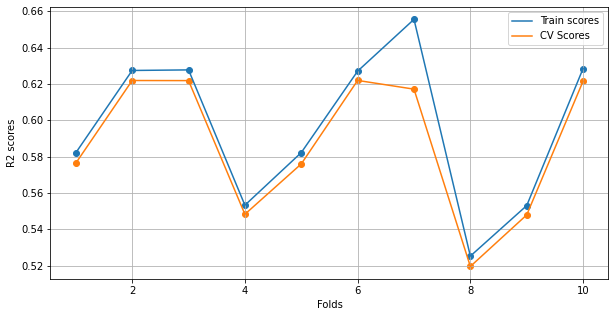

Best R2 score is  0.6218918572877454 and best hyperparameters is  {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 9, 'min_impurity_decrease': 0, 'max_features': 0.95, 'max_depth': 3}

Plot representing the feature importances for the best model selected from hyperparameter tuning


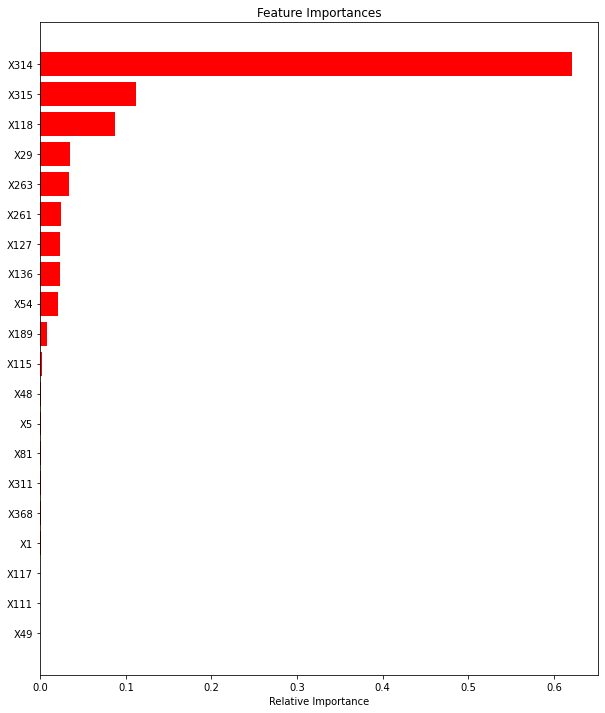

In [26]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_rf_model = ensemble(model,params,label_train)

# Best model from the hyperparameter tuning
label_rf_final = label_rf_model.best_estimator_
label_rf_final.fit(label_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_rf_final,label_train)

# Final submission.csv for kaggle scores
label_submission = submission(label_rf_final,label_test)
save_model('label_rf_final',label_rf_final)

##### From above feature importances plot we can see that top features are numerical features.

In [27]:
label_submission.to_csv('label_submission/label_rf_submission.csv',index = False)

#### Mean Encoding

In [28]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


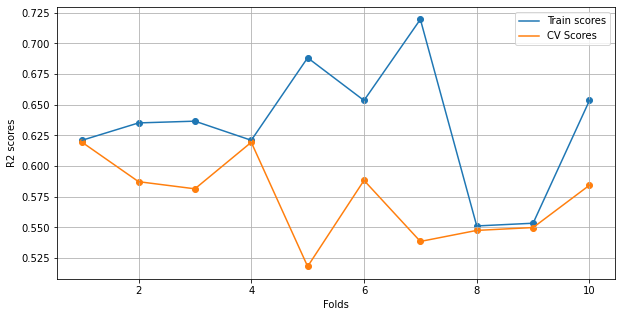

Best R2 score is  0.6193792778760856 and best hyperparameters is  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.001, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


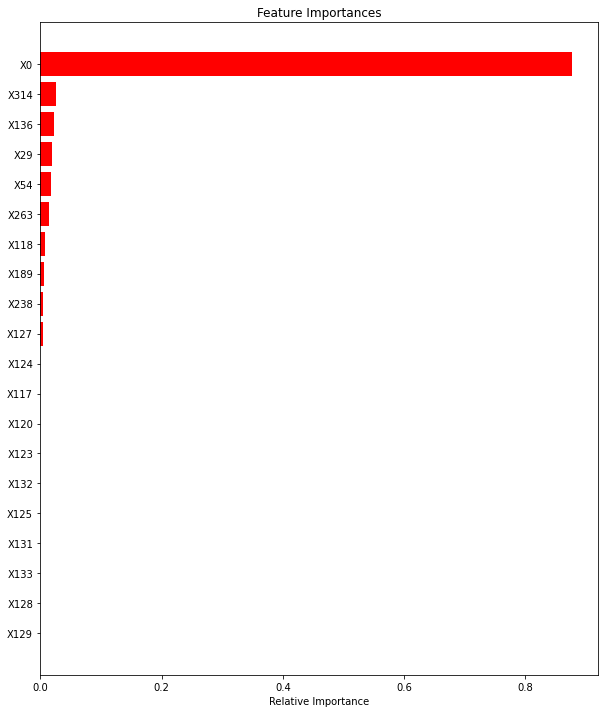

In [29]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_rf_model = ensemble(model,params,mean_train)

# Best model from the hyperparameter tuning
mean_rf_final = mean_rf_model.best_estimator_
mean_rf_final.fit(mean_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_rf_final,mean_train)

# Final submission.csv for kaggle scores
mean_submission = submission(mean_rf_final,mean_test)
save_model('mean_rf_final',mean_rf_final)

##### From above feature importances plot we can see that top feature is categorical and rest are all numeric

In [30]:
mean_submission.to_csv('mean_submission/mean_rf_submission.csv',index = False)

#### GLMM Encoding

In [31]:
params = {'n_estimators':[100,150,200,300,350,500],
         'max_depth':[2,3,5,7,10],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


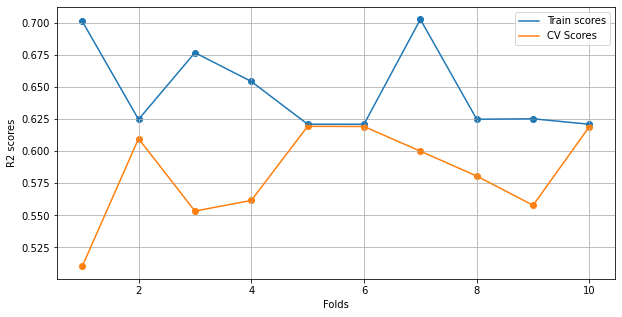

Best R2 score is  0.6193681813767913 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0001, 'max_features': 0.95, 'max_depth': 2}

Plot representing the feature importances for the best model selected from hyperparameter tuning


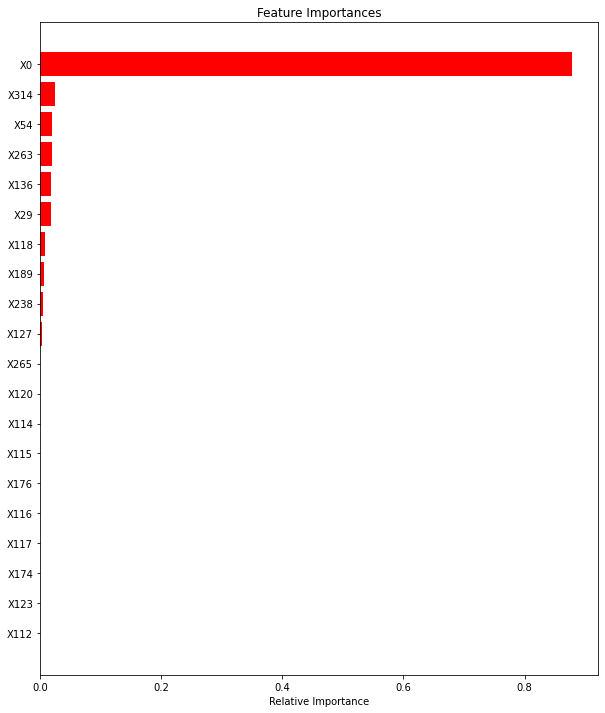

In [32]:
model = RandomForestRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_rf_model = ensemble(model,params,glmm_train)

# Best model from the hyperparameter tuning
glmm_rf_final = glmm_rf_model.best_estimator_
glmm_rf_final.fit(glmm_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_rf_final,glmm_train)

# Final submission.csv for kaggle scores
glmm_submission = submission(glmm_rf_final,glmm_test)
save_model('glmm_rf_final',glmm_rf_final)

##### From above feature importances plot we can see that in top features is categorical variables and rest are all numeric.

In [33]:
glmm_submission.to_csv('glmm_submission/glmm_rf_submission.csv',index = False)

### Extratrees Regressor

#### Label Encoding

In [34]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


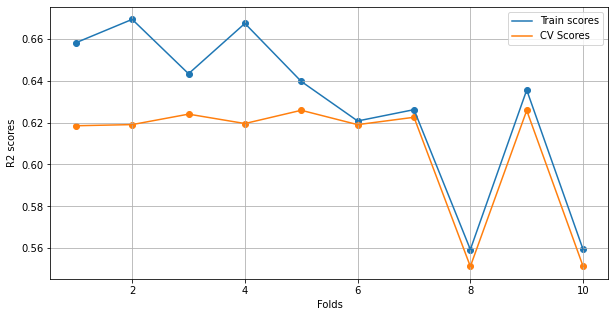

Best R2 score is  0.6258304640777568 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 7, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.001, 'max_features': 0.95, 'max_depth': 5}

Plot representing the feature importances for the best model selected from hyperparameter tuning


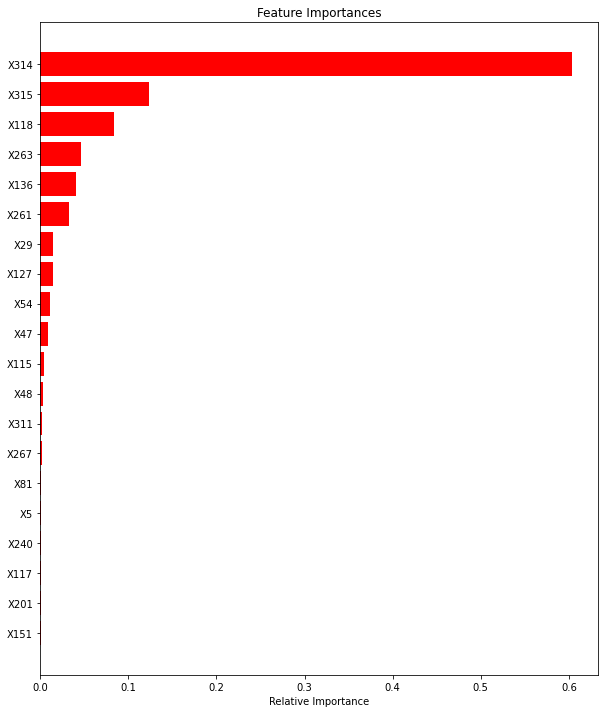

In [35]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_et_model = ensemble(model,params,label_train)

# Best model from the hyperparameter tuning
label_et_final = label_et_model.best_estimator_
label_et_final.fit(label_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(label_et_final,label_train)

# Final submission.csv for kaggle scores
label_submission = submission(label_et_final,label_test)
save_model('label_et_final',label_et_final)

##### From above feature importances plot we can see that top features are numerical features.

In [36]:
label_submission.to_csv('label_submission/label_et_submission.csv',index = False)

#### Mean Encoding

In [37]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


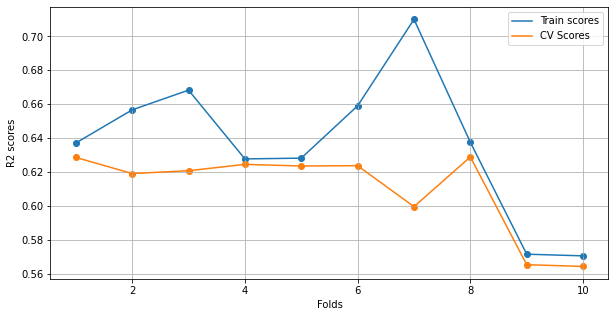

Best R2 score is  0.6288970735297209 and best hyperparameters is  {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.1, 'max_features': 0.95, 'max_depth': 5}

Plot representing the feature importances for the best model selected from hyperparameter tuning


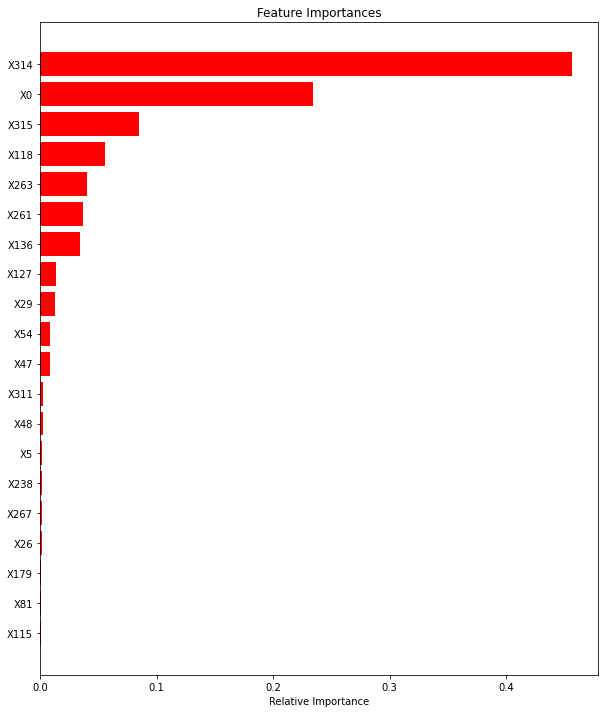

In [38]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_et_model = ensemble(model,params,mean_train)

# Best model from the hyperparameter tuning
mean_et_final = mean_et_model.best_estimator_
mean_et_final.fit(mean_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(mean_et_final,mean_train)

# Final submission.csv for kaggle scores
mean_submission = submission(mean_et_final,mean_test)
save_model('mean_et_final',mean_et_final)

##### From above feature importances plot we can see that among top features only one categorical and rest are all numeric.

In [39]:
mean_submission.to_csv('mean_submission/mean_et_submission.csv',index = False)

#### GLMM Encoding

In [40]:
params = {'n_estimators':[100,150,200,250,300,350,500],
         'max_depth':[2,3,4,5,7,8,9,10],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,10],
         'max_features':[0.95],
         'min_impurity_decrease':[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10]}

Plot representing the train and cv scores.


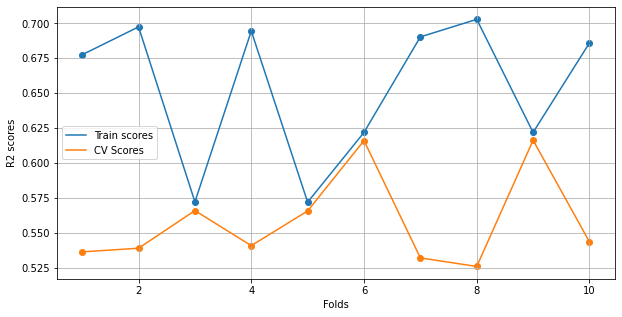

Best R2 score is  0.6162425187452423 and best hyperparameters is  {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 10, 'min_impurity_decrease': 1, 'max_features': 0.95, 'max_depth': 10}

Plot representing the feature importances for the best model selected from hyperparameter tuning


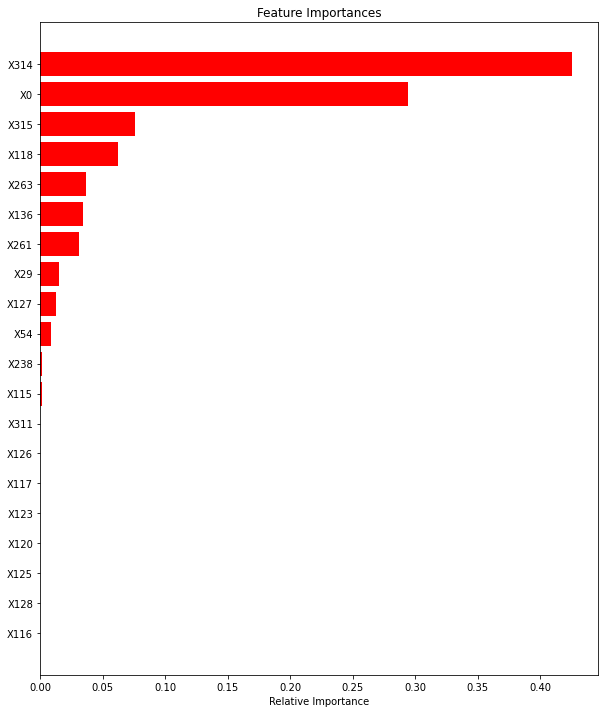

In [41]:
model = ExtraTreesRegressor(random_state = 42,n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_et_model = ensemble(model,params,glmm_train)

# Best model from the hyperparameter tuning
glmm_et_final = glmm_et_model.best_estimator_
glmm_et_final.fit(glmm_train,y_train['y'].values)

#Plotting feature importances for best model
print()
print('Plot representing the feature importances for the best model selected from hyperparameter tuning')
feature_imp(glmm_et_final,glmm_train)

# Final submission.csv for kaggle scores
glmm_submission = submission(glmm_et_final,glmm_test)
save_model('glmm_et_final',glmm_et_final)

##### From above feature importances plot we can see that in top features we have only one categorical and others are numerical

In [42]:
glmm_submission.to_csv('glmm_submission/glmm_et_submission.csv',index = False)

### XG Boost

#### Label Encoding

In [43]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


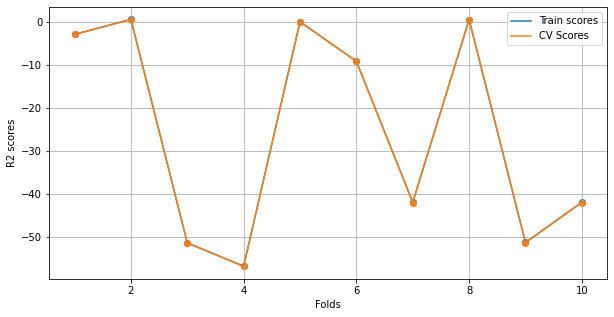

Best R2 score is  0.6002231112201778 and best hyperparameters is  {'subsample': 0.3, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 0.1}


In [44]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
label_xgb_model = ensemble(model,params,label_train)

# Best model from the hyperparameter tuning
label_xgb_final = label_xgb_model.best_estimator_
label_xgb_final.fit(label_train,y_train['y'].values)

# Final submission.csv for kaggle scores
label_submission = submission(label_xgb_final,label_test)
save_model('label_xgb_final',label_xgb_final)

In [45]:
label_submission.to_csv('label_submission/label_xgb_submission.csv',index = False)

#### Mean Encoding

In [46]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


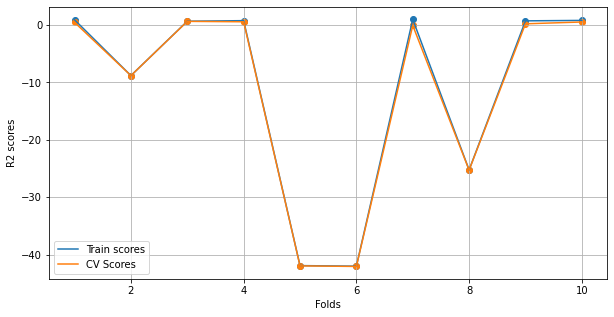

Best R2 score is  0.6099607375973247 and best hyperparameters is  {'subsample': 0.3, 'reg_alpha': 100, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}


In [47]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
mean_xgb_model = ensemble(model,params,mean_train)

# Best model from the hyperparameter tuning
mean_xgb_final = mean_xgb_model.best_estimator_
mean_xgb_final.fit(mean_train,y_train['y'].values)

# Final submission.csv for kaggle scores
mean_submission = submission(mean_xgb_final,mean_test)
save_model('mean_xgb_final',mean_xgb_final)

In [48]:
mean_submission.to_csv('mean_submission/mean_xgb_submission.csv',index = False)

#### GLMM encoding

In [49]:
params={'learning_rate':[0.001,0.01,0.05,0.1,1],
     'n_estimators':[100,150,200,250,500],
     'max_depth':[2,3,5,7,10],
    'colsample_bytree':[0.1,0.5,0.7,1],
    'subsample':[0.1,0.3,0.5,1],
      'gamma':[1e-3,1e-2,1e-1,0,0.5,1],
      'reg_alpha':[1e-5,1e-3,1e-1,1,10,100]}

Plot representing the train and cv scores.


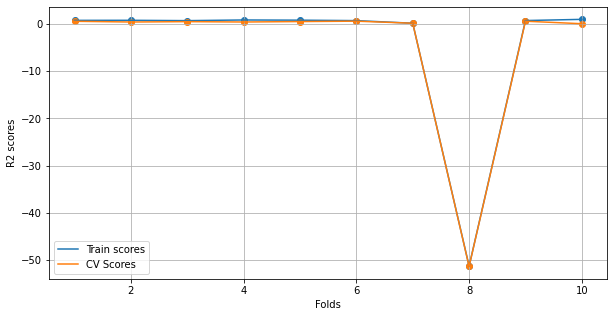

Best R2 score is  0.5865940691711693 and best hyperparameters is  {'subsample': 0.5, 'reg_alpha': 100, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


In [50]:
model = XGBRegressor(n_jobs = -1)
#Hyperparameter tuning of RF model
print('Plot representing the train and cv scores.')
glmm_xgb_model = ensemble(model,params,glmm_train)

# Best model from the hyperparameter tuning
glmm_xgb_final = glmm_xgb_model.best_estimator_
glmm_xgb_final.fit(glmm_train,y_train['y'].values)

# Final submission.csv for kaggle scores
glmm_submission = submission(glmm_xgb_final,glmm_test)
save_model('glmm_xgb_final',glmm_xgb_final)

In [51]:
glmm_submission.to_csv('glmm_submission/glmm_xgb_submission.csv',index = False)

### Stacked Models

#### I will be using stacked models of (Random Forest, XG bosst, Extra tree regresssor) on Label, Mean and GLMM encoding. Using Ridge as final meta regressor with regularization set to 0 so it doesn't impact stacked models. 

#### Label Encoding

In [52]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_label = StackingRegressor(estimators = [('rf',label_rf_final),('xgb',label_xgb_final),('et',label_et_final)],final_estimator = ridge,cv = cv_indices,n_jobs = -1)
stack_label.fit(label_train,y_train['y'].values)
                
# Final submission.csv for kaggle scores
label_submission = submission(stack_label,label_test)
save_model('stack_label',stack_label)

In [53]:
label_submission.to_csv('label_submission/label_stack_submission.csv',index = False)

#### Mean Encoding

In [54]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_mean = StackingRegressor(estimators = [('rf',mean_rf_final),('xgb',mean_xgb_final),('et',mean_et_final)],final_estimator = ridge,cv = cv_indices,n_jobs = -1)
stack_mean.fit(mean_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
mean_submission = submission(stack_mean,mean_test)
save_model('stack_mean',stack_mean)

In [55]:
mean_submission.to_csv('mean_submission/mean_stack_submission.csv',index = False)

#### Glmm Encoding

In [56]:
#Ridge as meta regressor
ridge = Ridge(alpha = 0,random_state = 42,fit_intercept = False)

#Stacking model
stack_glmm = StackingRegressor(estimators = [('rf',glmm_rf_final),('xgb',glmm_xgb_final),('et',glmm_et_final)],final_estimator = ridge,cv = cv_indices,n_jobs = -1)
stack_glmm.fit(glmm_train,y_train['y'].values)
    
# Final submission.csv for kaggle scores
glmm_submission = submission(stack_glmm,glmm_test)
save_model('stack_glmm',stack_glmm)

In [57]:
glmm_submission.to_csv('glmm_submission/glmm_stack_submission.csv',index = False)

## Leaderboard scores

In [58]:
from prettytable import PrettyTable
#Label Encoding
table = PrettyTable()
table.title = 'Label_Encoding'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.53199','0.53027'])
table.add_row(['Random Forests','0.54287','0.55286'])
table.add_row(['Extra Trees Regressor','0.54812','0.55296'])
table.add_row(['XGboost','0.54251','0.54610'])
table.add_row(['Stacked','0.54829','0.55422'])
print(table)
table = PrettyTable()
table.title = 'Mean_Encoding'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54314','0.55422'])
table.add_row(['Random Forests','0.53835','0.54787'])
table.add_row(['Extra Trees Regressor','0.54784','0.55305'])
table.add_row(['XGboost','0.53093','0.54117'])
table.add_row(['Stacked','0.54900','0.55436'])
print(table)
table = PrettyTable()
table.title = 'GLMM_Encoding'
table.field_names = ['Model','Private_Score','Public_Score']
table.add_row(['Lasso','0.54293','0.54674'])
table.add_row(['Random Forests','0.53980','0.54725'])
table.add_row(['Extra Trees Regressor','0.53994','0.54822'])
table.add_row(['XGboost','0.53586','0.54540'])
table.add_row(['Stacked','0.54317','0.55090'])
print(table)

+------------------------------------------------------+
|                    Label_Encoding                    |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.53199    |   0.53027    |
|     Random Forests    |    0.54287    |   0.55286    |
| Extra Trees Regressor |    0.54812    |   0.55296    |
|        XGboost        |    0.54251    |   0.54610    |
|        Stacked        |    0.54829    |   0.55422    |
+-----------------------+---------------+--------------+
+------------------------------------------------------+
|                    Mean_Encoding                     |
+-----------------------+---------------+--------------+
|         Model         | Private_Score | Public_Score |
+-----------------------+---------------+--------------+
|         Lasso         |    0.54314    |   0.55422    |
|     Random Forests    |    0.

## Conclusion

1. The above models are only encoding of features with no features added.
2. We can see that the models are overfitting from above scores.
4. Best models from above is Stacked model of Mean encoding with a private score of 0.54900.
5. Adding Interaction, PCA and TSVD features may reduce overfitting.